In [1]:
import os, sys
import requests
import pandas as pd
import numpy as np
from fbprophet import Prophet
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# API call paramenters

In [2]:
PROTOCOL        = "http"
API_LANG        = "en"
API_FMT         = "json"
API_DOMAIN      = 'ec.europa.eu/eurostat/wdds'
API_VERS        = 2.1
API_URL         = "{}://{}/rest/data/v{}/{}/{}".format(
                  PROTOCOL, API_DOMAIN, API_VERS, API_FMT, API_LANG
                  )
print(API_URL)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en


In [3]:
GEO             = "EU28"
# TIME : all
INDICATOR       = (u'tour_occ_nim', "Tour accomodation")
UNIT            = (u'NR', "Number of nights")
NACE_R2         = (u'I551', "Hotels; holiday and other short-stay accommodation...")
INDIC_TO        = (u'B006', "Nights spent, total")

In [4]:
url             = "{}/{}?geo={}&unit={}&nace_r2={}&indic_to={}".format(
                  API_URL, INDICATOR[0], GEO, UNIT[0], NACE_R2[0], INDIC_TO[0])
print(url)

http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/tour_occ_nim?geo=EU28&unit=NR&nace_r2=I551&indic_to=B006


# API Call Response

In [5]:
session = requests.session()
try:
    response = session.head(url)
    response.raise_for_status()
except:
    raise IOError("ERROR: wrong request formulated")  
else:
    print ("OK: status={}".format(response.status_code))
    
try:    
    response = session.get(url)
except:
    raise IOError('error retrieveing response from URL')

OK: status=200


# JSON Manipulation

In [33]:
# label to Index
resp = response.json()
lbl2idx = resp['dimension']['time']['category']['index']

# Index to Label
idx2lbl = {v:k for (k,v) in lbl2idx.items()}

# convert to series
date_index = pd.Series(idx2lbl, name='date_index')
#data_values = resp['value']

data = pd.DataFrame(resp['value'], index=['values']).T.reset_index()
data = pd.DataFrame.merge(data, date_index, left_index=True, right_index=True)

data.head()

,index,values,date_index
0,180,34915069,1990M01
1,181,36999190,1990M02
2,182,46423990,1990M03
3,183,45144992,1990M04
4,184,65209000,1990M05


In [10]:
table = data#.drop('index', 1)

In [11]:
table['date_index'] = table['date_index'].str.replace('M','-')

In [12]:
table = table.reset_index().set_index('index')

In [13]:
table = table.drop('level_0', 1)

In [14]:
table

,values,date_index
index,,
180,34915069,1990-01
181,36999190,1990-02
182,46423990,1990-03
183,45144992,1990-04
184,65209000,1990-05
...,...,...
715,93391063,2019-07
716,82145836,2019-08
898,80813747,2019-09


In [15]:
df_plot = table.sort_values('date_index')
ds_last = df_plot['date_index'].values[-1]

In [16]:
df_plot.dtypes

values         int64
date_index    object
dtype: object

In [17]:
df_plot['date_index'] = pd.to_datetime(df_plot['date_index'])

In [18]:
df_plot = df_plot.set_index('date_index')

# Plotting

In [19]:
#for seaborn error
'''
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
'''

'\nfrom pandas.plotting import register_matplotlib_converters\nregister_matplotlib_converters()\n'

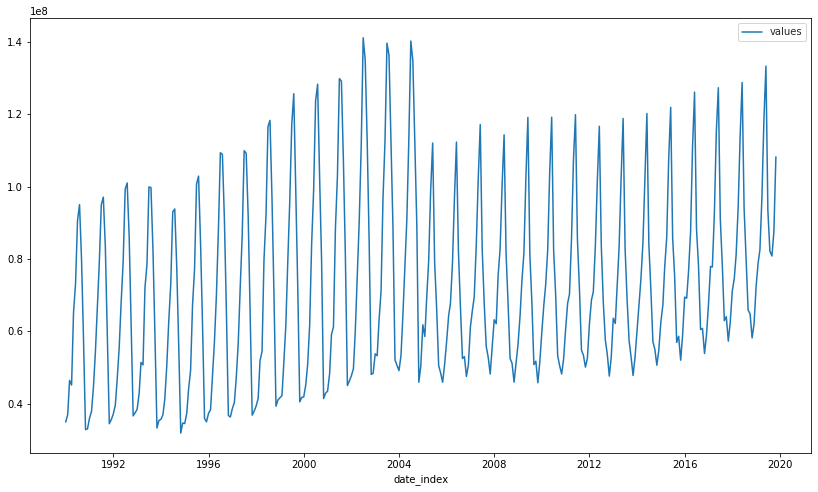

In [20]:
# Ex Seaborn plot

f, ax = plt.subplots(figsize=(14,8))
sns.set_style("darkgrid")
sns.set_style("ticks", 
              {"xtick.major.size":16,"ytick.major.size":16}
             )
sns.axes_style("darkgrid")

g = sns.lineplot(data=df_plot)

In [21]:
df = pd.DataFrame(columns=['ds','y'])

In [22]:
df['ds'] = df_plot.index
df['y'] = df_plot.values

In [23]:
df

,ds,y
0,1990-01-01,34915069
1,1990-02-01,36999190
2,1990-03-01,46423990
3,1990-04-01,45144992
4,1990-05-01,65209000
...,...,...
354,2019-07-01,93391063
355,2019-08-01,82145836
356,2019-09-01,80813747
357,2019-10-01,87420210


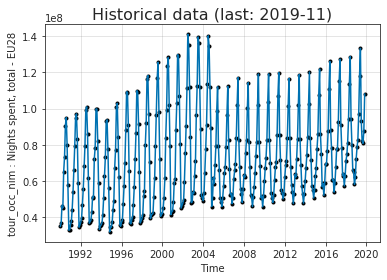

In [24]:
xlabel = "Time"
ylabel = "{} : {} - {}".format(INDICATOR[0], INDIC_TO[1], GEO)  
plt.plot(df['ds'], df['y'], 'k.')
plt.plot(df['ds'], df['y'], ls='-', c='#0072B2')
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.title("Historical data (last: {})".format(ds_last), fontsize=16)
plt.show()

In [25]:
m = Prophet(growth = "linear", yearly_seasonality=True, weekly_seasonality=False)

In [26]:
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
nyears = 5
future = m.make_future_dataframe(periods=12*nyears, freq='M')
fcst = m.predict(future)

In [28]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
414,2024-06-30,1.088712e+08,8.957701e+07,1.272430e+08
415,2024-07-31,1.026039e+08,8.413309e+07,1.205501e+08
416,2024-08-31,8.576161e+07,6.735910e+07,1.044484e+08
417,2024-09-30,7.391311e+07,5.453792e+07,9.182156e+07
418,2024-10-31,5.849215e+07,4.128582e+07,7.789860e+07


Text(0.5, 1, 'Forecast data (5 years)')

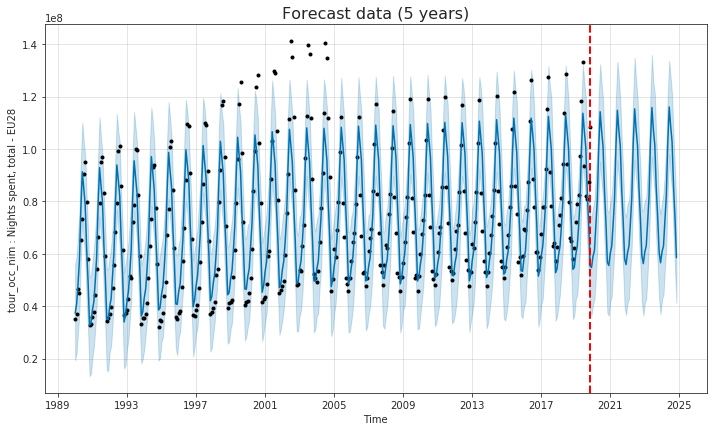

In [29]:
m.plot(fcst, uncertainty=True) 
plt.axvline(pd.to_datetime(ds_last), color='r', linestyle='--', lw=2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.title("Forecast data ({} years)".format(nyears), fontsize=16)

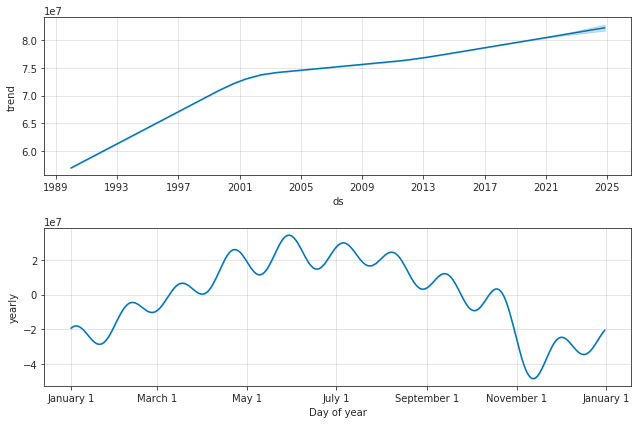

In [30]:
m.plot_components(fcst, uncertainty=True);